In [38]:
import itertools
import json
import pickle
import string
import numpy as np
import matplotlib.pyplot as plt

from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

from sklearn.decomposition import NMF, TruncatedSVD
from sklearn.naive_bayes import GaussianNB
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import confusion_matrix,roc_curve
from sklearn.model_selection import GridSearchCV


from nltk.corpus import stopwords
import pandas as pd


# Helper Functions

In [25]:
# Some global variables to help the helper functions
table = str.maketrans({key: None for key in string.punctuation})
english_stopwords = stopwords.words('english')
for n,stopword in enumerate(english_stopwords):
    english_stopwords[n] = stopword.translate(table).lower()
english_stopwords = set(english_stopwords)

def clean_tweet(tweet):
    # Split by white space
    words = tweet.split()
    # Remove anything with "@", "t.co","&"
    for n,word in enumerate(words):
        if "@" in word or "t.co" in word:# or "&" in word:
            words[n] = ""
        else:
            # Remove punctuation and lowercase
            words[n] = word.translate(table).lower()
            # Check if clean word in clean stopword set
            if words[n] in english_stopwords or not words[n].isalnum():
                words[n] = ""
            
    clean_tweet = " ".join(filter(None,words))
    return clean_tweet

def print_metrics(truth,pred):
    print('Accuracy: ' + str(metrics.accuracy_score(truth, pred)))
    print('Precision: ' + str(metrics.precision_score(truth, pred)))
    print('Recall: ' + str(metrics.recall_score(truth, pred)))
    print('F-1 Score: ' + str(metrics.f1_score(truth, pred)))
    
def plot_confusion_matrix(cm,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues,
                          classes = ['Massachussetts', 'Washington']
):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()
    
def roc_plotter(model, data, labels, clfType):
    if clfType == "LogisticRegression":
        scores = model.decision_function(data)
    elif clfType == "RandomForest":
        scores = model.predict_log_proba(data)[:,1]
    elif clfType =="NaiveBayes":
        scores = model.predict_log_proba(data)[:,1]
    else:
        print("Invalid clfType.")
        return
    fpr, tpr, thresholds = roc_curve(labels,scores)
    plt.plot(fpr,tpr)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')

# Generate Location-Based Dataset

In [49]:
DATA_DIRECTORY = "ECE219_tweet_data/"
filenames = ["tweets_#superbowl.txt"]

MASSACHUSETTS_FLAGS = ["Massachusetts","Boston","MA"]
WASHINGTON_FLAGS = ["Washington","Seattle","WA"]

tweetLocationDataset = []

with open(DATA_DIRECTORY+filenames[0]) as f:
    for line in f:
        json_tweet = json.loads(line)
        location = json_tweet['tweet']['user']['location']
        locationFoundFlag = False
        for m in MASSACHUSETTS_FLAGS:
            if m in location:
                locationFoundFlag = True
                tweetLocationDataset.append((json_tweet['tweet']['text'],"MA"))
                break
        if not locationFoundFlag:
            for w in WASHINGTON_FLAGS:
                if w in location:
                    locationFoundFlag = True
                    tweetLocationDataset.append((json_tweet['tweet']['text'],"WA"))
                                        
with open('locationBasedDataset.pickle', 'wb') as handle:
    pickle.dump(tweetLocationDataset, handle)


# Load Data If Already Generated

In [6]:
with open('locationBasedDataset.pickle','rb') as handle:
    tweetLocationDataset = pickle.load(handle)
    
data = np.array(tweetLocationDataset)

# Pre-Process Tweets

In [32]:
print("Number of Massachusetts tweets: %d" % sum(data[:,1] == "MA"))
print("Number of Washington tweets:    %d" % sum(data[:,1] == "WA"))

clean_data = set()

for i in range(len(data)):
    tweet = data[i,0]
    clean_data.add((clean_tweet(tweet),data[i,1]))
clean_data = list(clean_data)
clean_data = np.array(clean_data)

    
print("\nNumber of Unique Massachusetts tweets: %d" % sum(clean_data[:,1] == "MA"))
print("Number of Unique Washington tweets:    %d" % sum(clean_data[:,1] == "WA"))

print("\nCleaned Data Samples With Labels\n")
for i in range(100):
    print("Location " + clean_data[i,1] + ": " + clean_data[i,0])
    
np.random.shuffle(clean_data)

Number of Massachusetts tweets: 21195
Number of Washington tweets:    32441

Number of Unique Massachusetts tweets: 20186
Number of Unique Washington tweets:    25502

Cleaned Data Samples With Labels

Location WA: podcast going unbearable superbowl
Our @ButchStearns talked #Patriots w/3X #SuperBowl champ Matt Light Full interview @ 10 http://t.co/6s9XqUUcyj #FOX25 http://t.co/iTAFnwQc2G


Location MA: superbowl matchup israel connections covered via
#MondayMotivation #GOHAWKS #SEAHAWKS #superbowlbound #bodypaint  Happy Monday! &lt;3 http://t.co/MD0vGhP72K


Location WA: know chris matthews beforeyou know seahawks superbowlxlix
Interview With the Seattle Seahawks Superbowl Champions http://t.co/4HS6DYeOxV #Gohawks #superbowlxlviii #NFL #ESPN


Location WA: vs superbowl countdown game
@DougBaldwinJr just this #mediocre #SuperBowlChampion wide receiver #GoHawks #RePete http://t.co/HUwZhG6JwQ's video http://t.co/wE4PP5YaHd


Location WA: thats halftime seahawks patriots tied challengeofth

In [48]:
for i in range(100):
    print(data[i,0])
    print("")

Our @ButchStearns talked #Patriots w/3X #SuperBowl champ Matt Light Full interview @ 10 http://t.co/6s9XqUUcyj #FOX25 http://t.co/iTAFnwQc2G

#MondayMotivation #GOHAWKS #SEAHAWKS #superbowlbound #bodypaint  Happy Monday! &lt;3 http://t.co/MD0vGhP72K

Interview With the Seattle Seahawks Superbowl Champions http://t.co/4HS6DYeOxV #Gohawks #superbowlxlviii #NFL #ESPN

@DougBaldwinJr just this #mediocre #SuperBowlChampion wide receiver #GoHawks #RePete http://t.co/HUwZhG6JwQ's video http://t.co/wE4PP5YaHd

Just a #SuperBowlChampion  #Pedestrian wide receiver #GoHawks #RePete http://t.co/HUwZhG6JwQ's video http://t.co/XYQxeG6u6k

MT @Kantar: Fans of #SuperBowl TV ads, check out this very cool @KantarMediaUS roster of ad stats: http://t.co/5EbV2HxdtG #SuperBowlXLIX

@jc_nogales Sunday February 1st. Se juega en Arizona #SuperBowlXLIX

Cutest little Seahawks fan yet! #naturalhairbaby #naturalhair  #superbowl #Seattle #Seahawks http://t.co/MGTjfMPqVy

Kantar Media projects @UOPX will get $11M+ 

In [9]:
SPLIT_TRAIN_RATIO = 0.8
splitIndex = int(clean_data.shape[0]*SPLIT_TRAIN_RATIO)

vectorizer = TfidfVectorizer(min_df=15)
vectorized_tweets_train = vectorizer.fit_transform(clean_data[:splitIndex,0])
vectorized_tweets_test = vectorizer.transform(clean_data[splitIndex:,0])
binarized_labels = clean_data[:,1].copy()
for n,label in enumerate(binarized_labels):
    if label == "MA":
        binarized_labels[n] = 0
    else:
        binarized_labels[n] = 1
        
y_train = binarized_labels[:splitIndex].astype('int')
y_test = binarized_labels[splitIndex:].astype('int')
print("Vectorized Tweets Train shape: " + str(vectorized_tweets_train.shape))
print("Vectorized Tweets Test shape: " + str(vectorized_tweets_test.shape))

Vectorized Tweets Train shape: (36550, 2067)
Vectorized Tweets Test shape: (9138, 2067)


In [10]:
x_train = vectorized_tweets_train
x_test = vectorized_tweets_test

In [40]:
parameters = {'C':[10**-3,10**-2,10**-1,10**0,10**1,10**2,10**3]}
LogisticRegressionClassifier = LogisticRegression(penalty="l2")
logistic_l2_grid = GridSearchCV(LogisticRegressionClassifier, parameters,cv=5)
logistic_l2_grid.fit(x_train, y_train)
pd.DataFrame(logistic_l2_grid.cv_results_)[['param_C','mean_test_score']]

/Users/samyang/anaconda/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/Users/samyang/anaconda/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/Users/samyang/anaconda/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/Users/samyang/anaconda/lib/py

,param_C,mean_test_score
0,0.001,0.562052
1,0.01,0.693653
2,0.1,0.726320
3,1,0.725034
4,10,0.714884
5,100,0.712804
6,1000,0.712558


In [42]:
parameters = {'C':[10**-3,10**-2,10**-1,10**0,10**1,10**2,10**3]}
LogisticRegressionClassifier = LogisticRegression(penalty="l1")
logistic_l1_grid = GridSearchCV(LogisticRegressionClassifier, parameters,cv=5)
logistic_l1_grid.fit(x_train, y_train)
pd.DataFrame(logistic_l1_grid.cv_results_)[['param_C','mean_test_score']]

/Users/samyang/anaconda/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/Users/samyang/anaconda/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/Users/samyang/anaconda/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/Users/samyang/anaconda/lib/py

,param_C,mean_test_score
0,0.001,0.559152
1,0.01,0.660848
2,0.1,0.712093
3,1,0.728345
4,10,0.714856
5,100,0.712914
6,1000,0.712503


Accuracy: 0.721930400525
Precision: 0.705470530772
Recall: 0.855478775913
F-1 Score: 0.773266708307


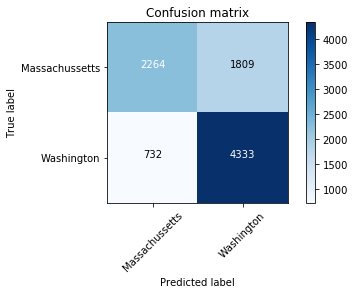

In [43]:
LogisticRegressionClassifier = LogisticRegression(penalty="l1",C=1)
LogisticRegressionClassifier.fit(x_train,y_train)
train_predictions = LogisticRegressionClassifier.predict(x_train)
test_predictions = LogisticRegressionClassifier.predict(x_test)

print_metrics(y_test,test_predictions)
plot_confusion_matrix(confusion_matrix(y_test,test_predictions))

In [45]:
parameters = {'max_depth':[2,5,10,15,20,30,40,50]}
rfc = RandomForestClassifier(max_depth=30)
rf_grid = GridSearchCV(rfc, parameters,cv=5)
rf_grid.fit(x_train, y_train)
pd.DataFrame(rf_grid.cv_results_)[['param_max_depth','mean_test_score']]

/Users/samyang/anaconda/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/Users/samyang/anaconda/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/Users/samyang/anaconda/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/Users/samyang/anaconda/lib/py

,param_max_depth,mean_test_score
0,2,0.608071
1,5,0.610643
2,10,0.678194
3,15,0.704487
4,20,0.710780
5,30,0.720903
6,40,0.719425
7,50,0.722845


Accuracy: 0.712300284526
Precision: 0.671500985638
Recall: 0.941559723593
F-1 Score: 0.783923728117


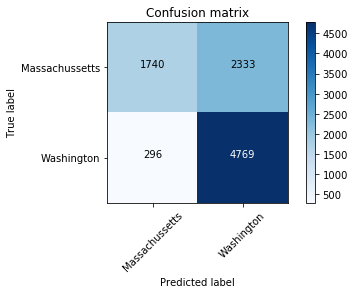

In [29]:
rfc = RandomForestClassifier(max_depth=30)
rfc.fit(x_train,y_train)
train_predictions = rfc.predict(x_train)
test_predictions = rfc.predict(x_test)

print_metrics(y_test,test_predictions)
plot_confusion_matrix(confusion_matrix(y_test,test_predictions))

Accuracy: 0.618187787262
Precision: 0.728405797101
Recall: 0.496150049358
F-1 Score: 0.590252495596


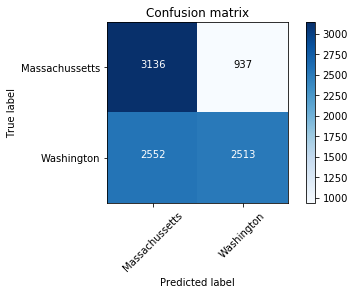

In [30]:
nb = GaussianNB()
nb.fit(x_train.toarray(),y_train)
train_predictions = nb.predict(x_train.toarray())
test_predictions = nb.predict(x_test.toarray())

print_metrics(y_test,test_predictions)
plot_confusion_matrix(confusion_matrix(y_test,test_predictions))


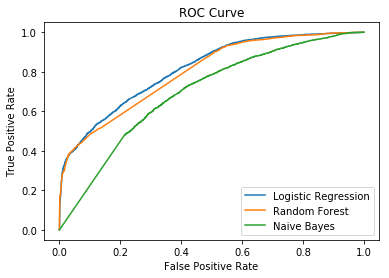

In [27]:
roc_plotter(LogisticRegressionClassifier,x_test,y_test,clfType="LogisticRegression")
roc_plotter(rfc,x_test,y_test,clfType="RandomForest")
roc_plotter(nb,x_test.toarray(),y_test,clfType="NaiveBayes")
plt.legend(["Logistic Regression", "Random Forest", "Naive Bayes"])

plt.show()

In [69]:
sorted_coef_indices = np.argsort(LogisticRegressionClassifier.coef_[0])

n_terms = 10

print("Terms corresponding to high confidence for Massachusetts:")
for i in range(n_terms):
    for word in vectorizer.vocabulary_:
        if vectorizer.vocabulary_[word] == sorted_coef_indices[i]:
            print(word + ', weight = ' + str(LogisticRegressionClassifier.coef_[0][sorted_coef_indices[i]]))

print("\nTerms corresponding to high confidence for Washington:")
for i in range(n_terms+1):
    if i == 0:
        continue
    for word in vectorizer.vocabulary_:
        if vectorizer.vocabulary_[word] == sorted_coef_indices[-i]:
            print(word + ', weight = ' + str(LogisticRegressionClassifier.coef_[0][sorted_coef_indices[-i]]))

Terms corresponding to high confidence for Massachusetts:
patriots, weight = -6.43917065456
gopats, weight = -6.1232834672
gopatriots, weight = -5.92751958644
7news, weight = -5.70939448314
boston, weight = -5.46642246906
wbz, weight = -5.4412693323
patriotsnation, weight = -5.42566400697
patsnation, weight = -4.79224094029
wcvb, weight = -4.31701551609
pats, weight = -4.29733638712

Terms corresponding to high confidence for Washington:
gohawks, weight = 13.8004922101
hawks, weight = 6.78421098619
12thman, weight = 6.33881715786
seahawks, weight = 5.67398402486
12s, weight = 5.10488783856
goseahawks, weight = 4.76809924668
repete, weight = 4.05050032111
dc, weight = 3.90776976408
q13fox, weight = 3.6601940557
twelfie, weight = 3.3920750668
